# Modelagem

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import warnings

# remoção segura para deixar o log mais limpo
warnings.filterwarnings("ignore", message="X does not have valid feature names") 

## Pré-processamento dos dados para o modelo 

Leitura do dataset de features e covertendo os tipos dos dados

In [45]:
# Leitura do dataset
dataset_features_v1 = pd.read_csv('../data/processed/dataset_features_v1.csv')

# Conversão dos tipos numéricos e categóricos
dataset_features_v1 = dataset_features_v1.astype({
    'ID_CLIENTE': 'int64',
    'VALOR_A_PAGAR': 'float64',
    'TAXA': 'float64',
    'RENDA_MES_ANTERIOR': 'float64',
    'NO_FUNCIONARIOS': 'int64',
    'FLAG_PF': 'int64',
    'DIAS_ATRASO': 'int64',
    'TARGET_INADIMPLENCIA': 'int64',
    'DIAS_ADIANTAMENTO': 'int64',
    'TEMPO_DE_CASA_MESES': 'int64',
    'PRAZO_PAGAMENTO_DIAS': 'int64',
    'MES_SAFRA': 'int32',
    'INADIMPLENCIAS_ANTERIORES': 'int64',
    'SEGMENTO_INDUSTRIAL': 'category',
    'DOMINIO_EMAIL': 'category',
    'PORTE': 'category',
    'CEP_2_DIG': 'category',
})

# Conversão de datas
dataset_features_v1['SAFRA_REF'] = pd.to_datetime(
    dataset_features_v1['SAFRA_REF'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_EMISSAO_DOCUMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_PAGAMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_PAGAMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_VENCIMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_VENCIMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_CADASTRO'] = pd.to_datetime(
    dataset_features_v1['DATA_CADASTRO'], format='%Y-%m-%d', errors='coerce'
)


C:\Users\Matheus\AppData\Local\Temp\ipykernel_15072\3995269983.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_features_v1 = pd.read_csv('../data/processed/dataset_features_v1.csv')


In [46]:
dataset_features_v1.dtypes

ID_CLIENTE                            int64
SAFRA_REF                    datetime64[ns]
DATA_EMISSAO_DOCUMENTO       datetime64[ns]
DATA_PAGAMENTO               datetime64[ns]
DATA_VENCIMENTO              datetime64[ns]
VALOR_A_PAGAR                       float64
TAXA                                float64
RENDA_MES_ANTERIOR                  float64
NO_FUNCIONARIOS                       int64
DATA_CADASTRO                datetime64[ns]
FLAG_PF                               int64
SEGMENTO_INDUSTRIAL                category
DOMINIO_EMAIL                      category
PORTE                              category
CEP_2_DIG                          category
DIAS_ATRASO                           int64
TARGET_INADIMPLENCIA                  int64
DIAS_ADIANTAMENTO                     int64
TEMPO_DE_CASA_MESES                   int64
PRAZO_PAGAMENTO_DIAS                  int64
MES_SAFRA                             int32
INADIMPLENCIAS_ANTERIORES             int64
dtype: object

Colunas a serem removidas:

- ID_CLIENTE: funciona como um identificador, não possui informação útil para predição.
- DATA_EMISSAO_DOCUMENTO, DATA_PAGAMENTO, DATA_VENCIMENTO, DATA_CADASTRO, SAFRA_REF: São datas brutas. foram transformadas em variáveis derivadas.
- DIAS_ATRASO, DIAS_ADIANTAMENTO: colunas que só são conhecidas quando se sabe sobre a variável target. São removidas para evitar datal leakage e consequentemente overfitting


Colunas categóricas a serem tratadas: 
- SEGMENTO_INDUSTRIAL, PORTE, DOMINIO_EMAIL: aplicão One-Hot Encoding pois são váriáveis categóricas de baixa cardinalidade

In [47]:
# Eliminar colunas irrelevantes
cols_drop = [
    'ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
    'DATA_VENCIMENTO', 'DATA_CADASTRO', 'SAFRA_REF', 'CEP_2_DIG', # CEP_2_DIG foi removido temporariamente
    'DIAS_ATRASO', 'DIAS_ADIANTAMENTO', # Colunas que só são conhecidas depois do treinamento. São removidas para evitar data leakage
    'INADIMPLENCIAS_ANTERIORES', # não configura-se como data leakage pois não contabiliza a inadimplência do pagamento atual
]

df = dataset_features_v1.drop(columns=cols_drop)


# Aplicando One-Hot Encoding em variáveis categóricas de baixa cardinalidade
df = pd.get_dummies(df, columns=['SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL'], drop_first=True)

X = df.drop(columns='TARGET_INADIMPLENCIA')
y = df['TARGET_INADIMPLENCIA']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [48]:
# Para o XGBoost.
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

modelos_parametros = {
    "XGBoost": (
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ),
        {
            "clf__n_estimators": [100, 200, 300],
            "clf__max_depth": [3, 5, 7, 10],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8, 1.0],
            "clf__gamma": [0, 1, 5],  # controle da complexidade
            "clf__min_child_weight": [1, 5, 10],  # regularização de folhas
        }
    ),
    
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "clf__n_estimators": [100, 200, 300],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ['sqrt', 'log2'],  # diversificação
            "clf__bootstrap": [True, False]
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42),
        {
            "clf__C": [0.1, 1.0, 10.0]
        }
    ),
    "LightGBM": (
        LGBMClassifier(random_state=42, verbose=-1),
        {
            "clf__n_estimators": [100, 200],
            "clf__num_leaves": [31, 50],
            "clf__learning_rate": [0.01, 0.1]
        }
    )
}

# Validação cruzada e execução 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = {}

for nome, (modelo, grid_params) in modelos_parametros.items():
    print(f"\nTreinando: {nome}")
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("clf", modelo)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=grid_params,
        cv=cv,
        scoring="roc_auc",
        verbose=3,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    resultados[nome] = {
        "Melhores parâmetros": grid.best_params_,
        "ROC AUC (validação)": grid.best_score_,
        "ROC AUC (teste)": roc_auc_score(y_test, y_proba),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist()
    }


Treinando: XGBoost
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


KeyboardInterrupt: 


=== XGBoost ===
Melhores parâmetros: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
ROC AUC (validação): 0.9353
ROC AUC (teste): 0.9352
Classification Report:
              precision    recall  f1-score       support
0              0.972645  0.966200  0.969412  13432.000000
1              0.606926  0.657598  0.631247   1066.000000
accuracy       0.943509  0.943509  0.943509      0.943509
macro avg      0.789786  0.811899  0.800329  14498.000000
weighted avg   0.945755  0.943509  0.944547  14498.000000
Confusion Matrix:


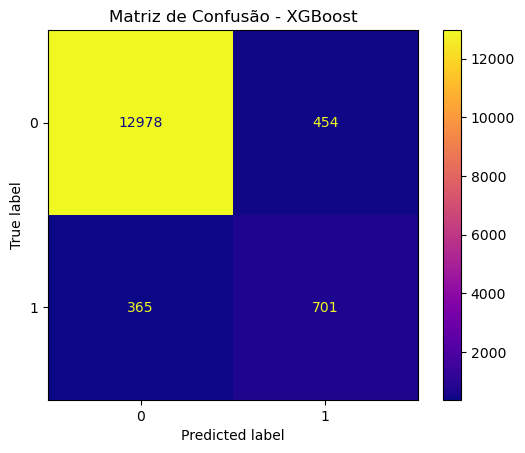


=== RandomForest ===
Melhores parâmetros: {'clf__max_depth': None, 'clf__n_estimators': 200}
ROC AUC (validação): 0.953
ROC AUC (teste): 0.9518
Classification Report:
              precision    recall  f1-score       support
0              0.978939  0.968955  0.973922  13432.000000
1              0.653367  0.737336  0.692816   1066.000000
accuracy       0.951924  0.951924  0.951924      0.951924
macro avg      0.816153  0.853145  0.833369  14498.000000
weighted avg   0.955001  0.951924  0.953253  14498.000000
Confusion Matrix:


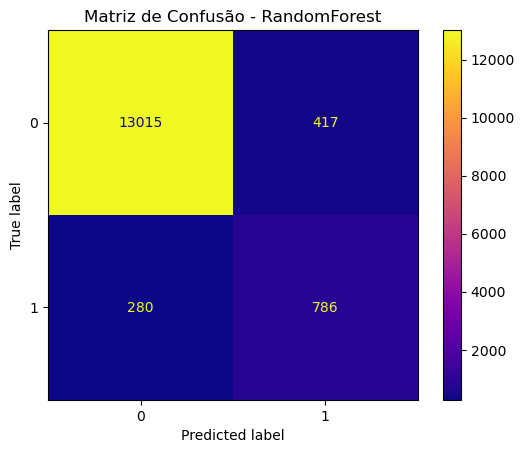


=== LogisticRegression ===
Melhores parâmetros: {'clf__C': 10.0}
ROC AUC (validação): 0.7653
ROC AUC (teste): 0.7706
Classification Report:
              precision    recall  f1-score       support
0              0.967373  0.737269  0.836791  13432.000000
1              0.171791  0.686679  0.274826   1066.000000
accuracy       0.733549  0.733549  0.733549      0.733549
macro avg      0.569582  0.711974  0.555809  14498.000000
weighted avg   0.908876  0.733549  0.795471  14498.000000
Confusion Matrix:


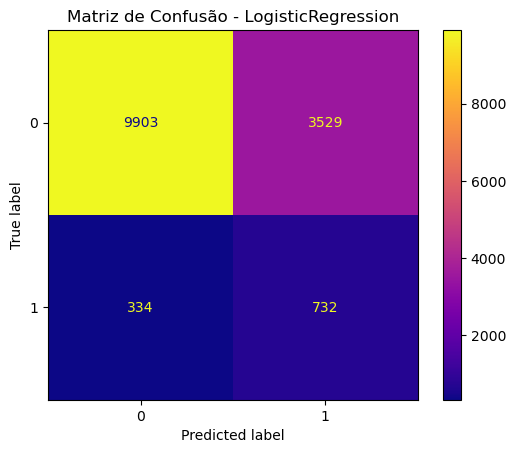


=== LightGBM ===
Melhores parâmetros: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200, 'clf__num_leaves': 50}
ROC AUC (validação): 0.9381
ROC AUC (teste): 0.9365
Classification Report:
              precision    recall  f1-score       support
0              0.972419  0.971188  0.971803  13432.000000
1              0.642659  0.652908  0.647743   1066.000000
accuracy       0.947786  0.947786  0.947786      0.947786
macro avg      0.807539  0.812048  0.809773  14498.000000
weighted avg   0.948173  0.947786  0.947976  14498.000000
Confusion Matrix:


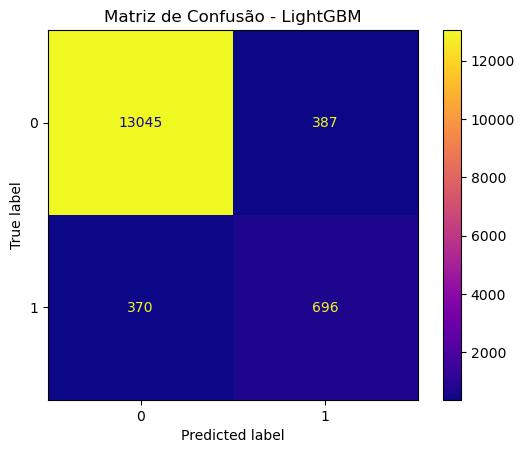

In [ ]:
# Resultados Finais 
for nome, res in resultados.items():
    print(f"\n=== {nome} ===")
    print("Melhores parâmetros:", res["Melhores parâmetros"])
    print("ROC AUC (validação):", round(res["ROC AUC (validação)"], 4))
    print("ROC AUC (teste):", round(res["ROC AUC (teste)"], 4))
    print("Classification Report:")
    print(pd.DataFrame(res["Classification Report"]).T)
    print("Confusion Matrix:")
    #print(np.array(res["Confusion Matrix"]))
    # plotando a matriz de confusão 
    cm = np.array(res["Confusion Matrix"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="plasma", values_format="d")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.show()

In [ ]:
# testar esta gama de parâmetros mais tarde 

'''
modelos_parametros = {
    "XGBoost": (
        XGBClassifier(
            use_label_encoder=False,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ),
        {
            "clf__n_estimators": [100, 200, 300],
            "clf__max_depth": [3, 5, 7, 10],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8, 1.0],
            "clf__gamma": [0, 1, 5],  # controle da complexidade
            "clf__min_child_weight": [1, 5, 10],  # regularização de folhas
        }
    ),
    
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "clf__n_estimators": [100, 200, 300],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ['sqrt', 'log2'],  # diversificação
            "clf__bootstrap": [True, False]
        }
    ),

    "LogisticRegression": (
        LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42),
        {
            "clf__C": [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    ),

    "LightGBM": (
        LGBMClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200, 300],
            "clf__num_leaves": [31, 50, 100],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__min_child_samples": [10, 20, 50],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8, 1.0]
        }
    )
}
'''

In [ ]:
'''# Para o XGBoost.
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

modelos_parametros = {
    "XGBoost": (
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            #scale_pos_weight=scale_pos_weight, # ignorado pois já usamos SMOTE
            random_state=42
        ),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 5, 7],
            "clf__learning_rate": [0.01, 0.1],
            "clf__subsample": [0.8],
            "clf__colsample_bytree": [0.8]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10],
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42),
        {
            "clf__C": [0.1, 1.0, 10.0]
        }
    ),
    "LightGBM": (
        LGBMClassifier(random_state=42, verbose=-1),
        {
            "clf__n_estimators": [100, 200],
            "clf__num_leaves": [31, 50],
            "clf__learning_rate": [0.01, 0.1]
        }
    )
}

# Validação cruzada e execução 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = {}

for nome, (modelo, grid_params) in modelos_parametros.items():
    print(f"\nTreinando: {nome}")
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("clf", modelo)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=grid_params,
        cv=cv,
        scoring="roc_auc",
        verbose=1,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    resultados[nome] = {
        "Melhores parâmetros": grid.best_params_,
        "ROC AUC (validação)": grid.best_score_,
        "ROC AUC (teste)": roc_auc_score(y_test, y_proba),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist()
    }

# Resultados Finais 
for nome, res in resultados.items():
    print(f"\n=== {nome} ===")
    print("Melhores parâmetros:", res["Melhores parâmetros"])
    print("ROC AUC (validação):", round(res["ROC AUC (validação)"], 4))
    print("ROC AUC (teste):", round(res["ROC AUC (teste)"], 4))
    print("Classification Report:")
    print(pd.DataFrame(res["Classification Report"]).T)
    print("Confusion Matrix:")
    print(np.array(res["Confusion Matrix"])'''

'# Para o XGBoost.\nscale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()\n\nmodelos_parametros = {\n    "XGBoost": (\n        XGBClassifier(\n            objective="binary:logistic",\n            eval_metric="logloss",\n            #scale_pos_weight=scale_pos_weight, # ignorado pois já usamos SMOTE\n            random_state=42\n        ),\n        {\n            "clf__n_estimators": [100, 200],\n            "clf__max_depth": [3, 5, 7],\n            "clf__learning_rate": [0.01, 0.1],\n            "clf__subsample": [0.8],\n            "clf__colsample_bytree": [0.8]\n        }\n    ),\n    "RandomForest": (\n        RandomForestClassifier(random_state=42),\n        {\n            "clf__n_estimators": [100, 200],\n            "clf__max_depth": [None, 10],\n        }\n    ),\n    "LogisticRegression": (\n        LogisticRegression(max_iter=1000, solver=\'lbfgs\', random_state=42),\n        {\n            "clf__C": [0.1, 1.0, 10.0]\n        }\n    ),\n    "LightGBM": (\n        LGB